## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [2]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/Self Case Study 2")   

Model 1 is an enocoder- decoder model. where enocder is used to extract the image features and decoder is used to generate the corresponding medical report

## ChexNet Model

For extracting the image fetaures from the x-ray, we use a pretrained CheXNet model

In [4]:

'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

chexnet_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

We have loaded the pre-trained chexnet model. Now we don't need the whole model. So we remove the last layer, and we take the output from the second last layer and consider it as the image features

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")


In [ ]:
tf.keras.utils.plot_model(final_chexnet_model,show_shapes=True,show_layer_names=True,to_file="chex.png") 

Output hidden; open in https://colab.research.google.com to view.

In our data frame, we are considering two images per patient. So we take two inputs one for each image and we give them to the encoder model. So we get two image features. We concatenate these features, and conider the resultant vector as the final encoder output. So the resultant shape of the vector will be 2048

### Features Extraction of image features from the Chexnet Model

Here we give the two x-rays of each patient to the final chexnet model. So this will return two feature vectors. Now we concatenate these feature vectors and get the final image feature for a patient

In [6]:
image_1= Input(shape=(224,224,3),name="image_1_features")
image_2= Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)
feature_extraction_model.summary() 

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_2_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Chexnet_model (Functional)      (None, 1024)         7037504     image_1_features[0][0]           
                                                                 image_2_features[0][0]           
__________________________________________________________________________________________________
final_image_features (Concatena (None, 2048)         0           Chexnet_model[0][0]   

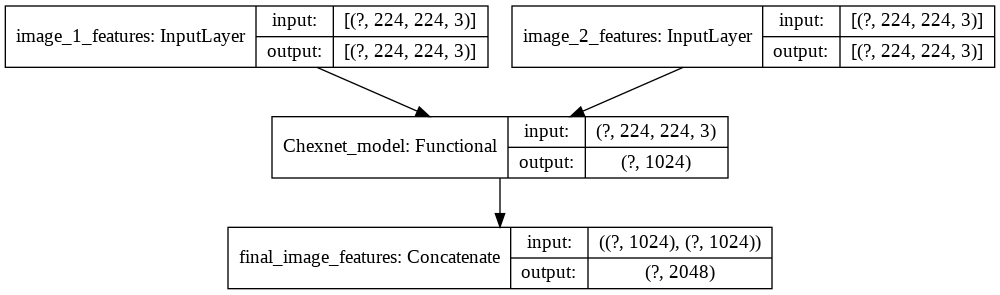

In [ ]:
tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True) 

Now we need to prepare the data to be given into the encoder-decoder model. The inputs to the encoder model is:

1. The image feature corresponding to the x-rays of every patient

The encoder model will do have some layers that transform this 2048 dimensional image features into a lower dimensional tensor

The input to the decoder are:

1. The image feature vector output from the encoder model

2. The text embeddings for the report

In [11]:
#first we split the data set into train and test data sets
data=pd.read_csv("data.csv")

train,test=train_test_split(data,test_size=0.2,random_state=1,shuffle=True)
print(train.shape) 
print(test.shape)

(3056, 5)
(764, 5)


In [ ]:
print(train)

      Unnamed: 0  ...                                             report
2314        2314  ...  cardiomediastinal silhouettes are within norma...
2761        2761  ...  normal heart size and mediastinal contours. fo...
2226        2226  ...  stable calcified hilar and granulomas. lungs a...
180          180  ...  comparison chest . well expanded and clear lun...
823          823  ...  patchy bilateral airspace disease with pulmona...
...          ...  ...                                                ...
2763        2763  ...  there irregular opacity projecting over the le...
905          905  ...  low lung volumes are present. the heart size a...
1096        1096  ...  the heart size normal. the mediastinal contour...
235          235  ...  chest. mildly hyperexpanded lungs. the right l...
1061        1061  ...  the trachea midline. the cardiomediastinal sil...

[3056 rows x 5 columns]


Now, for each patient, we need to extract the image features corresponding to xray1 and xray2, using the feature extraction model

In [13]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature

In [ ]:
train_features=[]
test_features=[]
for row in tqdm(range(train.shape[0])):
  image_1=train.iloc[row]["image1"]
  image_2=train.iloc[row]["image2"]
  train_features.append(image_feature_extraction(image_1,image_2))
print("DONE")
for row in tqdm(range(test.shape[0])):
  image_1=test.iloc[row]["image1"] 
  image_2=test.iloc[row]["image2"]
  test_features.append(image_feature_extraction(image_1,image_2))


  0%|          | 0/764 [00:00<?, ?it/s]

DONE


100%|██████████| 764/764 [09:56<00:00,  1.28it/s]


In [ ]:
# train["image_features"]=train_features
# test["image_features"]=test_features

# np.save("train_image_features",train_features)
# np.save("test_image_features",test_features) 

In [7]:
train_features=np.load("train_image_features.npz")
train_features=train_features['arr_0']
test_features=np.load("test_image_features.npz")
test_features=test_features['arr_0']
print(train_features.shape)

(3056, 1, 2048)


In [14]:
k=100
print(test_features[k])
one=test.iloc[k]["image1"] 
two=test.iloc[k]["image2"]
print(image_feature_extraction(one,two))   

[[0.         0.00129178 0.00234105 ... 0.8760509  0.9548157  0.7254444 ]]
tf.Tensor([[0.         0.00129178 0.00234105 ... 0.876052   0.9548154  0.7254452 ]], shape=(1, 2048), dtype=float32)


In [15]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]


In [ ]:
print(train_report[0])
print(train_report[1])

<sos> cardiomediastinal silhouettes are within normal limits. lungs are clear without focal consolidation pneumothorax pleural effusion. bony thorax unremarkable.  <eos>
<sos> normal heart size and mediastinal contours. focal airspace consolidation. tracheostomy tip approximately above the carina. pleural effusion pneumothorax.  <eos>


In [16]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 


Now for each word token, we use pretrained Glove Vectors for emdedding it into a 300 dimensional space. So using all the tokens, we construct the embedding matrix of shape (vocab size, 300)

In [17]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 

100%|██████████| 2016/2016 [00:00<00:00, 329914.82it/s]

Done


## The encoder_decoder model architecture

In [18]:
max_len=80

In [19]:
#constructing the encoder-decoder model

#encoder model
input_1=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="enc_dense")(input_1)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_out= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(embedding_out)

lstm_out= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")(lstm_out) 

x=Dropout(0.5)(lstm_out)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed =1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[input_1,input_text],outputs=x1)
encoder_decoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      605100      text[0][0]                       
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 80, 256)      570368      embedding[0][0]                  
__________________________________________________________________________________________________
Images (InputLayer)             [(None, 2048)]       0                                            
_______________________________________________________________________________________

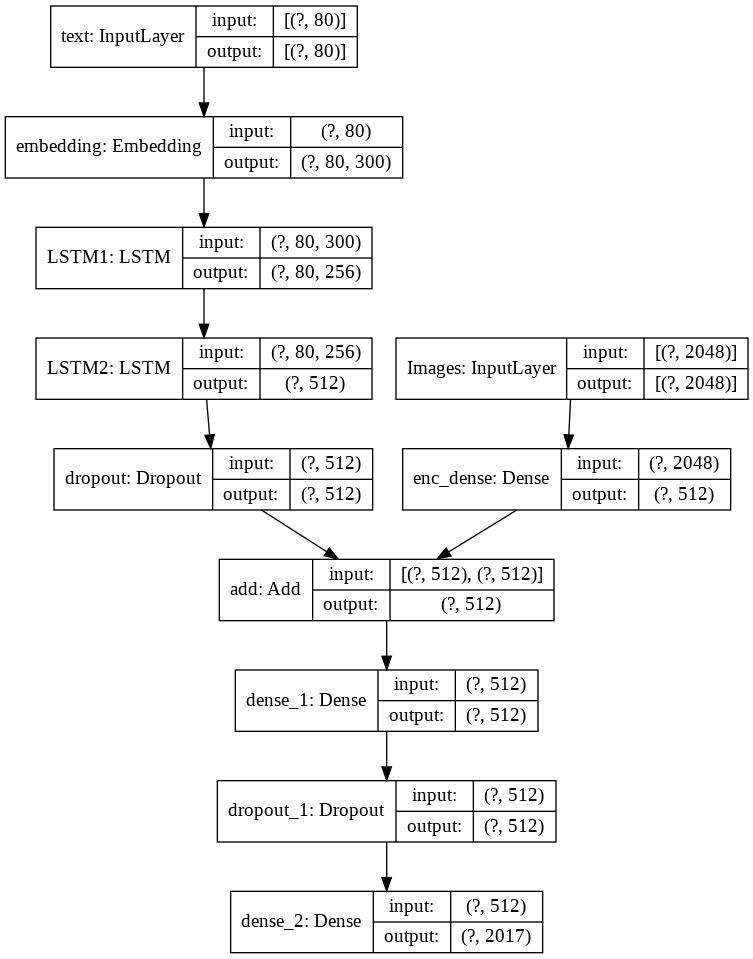

In [20]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True,show_layer_names=True,to_file="model1.png") 

In [ ]:
batch_size=20

In [ ]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_report))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_report))
test_dataset = test_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 


In [ ]:
#printing the last batch of train dataset
for element in train_dataset:
  pass
print(element) 

(<tf.Tensor: shape=(16, 1, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 2.5970144e-03, 1.1333722e-03, ...,
         8.0173320e-01, 8.7154669e-01, 6.5596563e-01]],

       [[4.3033747e-06, 2.0106875e-03, 1.5523051e-03, ...,
         8.4751791e-01, 8.4052759e-01, 7.0260876e-01]],

       [[0.0000000e+00, 1.9841548e-03, 2.4803372e-03, ...,
         8.0807626e-01, 8.7097371e-01, 6.6687274e-01]],

       ...,

       [[1.9984741e-07, 2.1698354e-03, 1.7109234e-03, ...,
         8.0552274e-01, 8.2921755e-01, 6.5617543e-01]],

       [[5.5605778e-07, 1.5250441e-03, 1.8228093e-03, ...,
         8.3283418e-01, 8.5461891e-01, 6.7872393e-01]],

       [[1.4062722e-04, 1.7770568e-03, 2.2063763e-03, ...,
         8.0193609e-01, 8.5606605e-01, 6.5645057e-01]]], dtype=float32)>, <tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'<sos> radiographic attenuation obscures detail. grossly the lungs are clear and expanded. heart large. pulmonary are normal.  <eos>',
       b'<sos> lungs are rela

In [ ]:
'''
Here we load the data to be tained. For each batch from train dataset, we prepare the data like:
for report1, image1 in each batch:
  report is tokenized
  input1= token of <sos>----> 
  output1=<token of next_word in report1>
  image=image1

  input2=token of <sos><token of second word in report1>
  output1=<token of third word>
  image=image1
  .
  .
  .

'''
def load_data(images,reports_unpadded):
    #images=tf.reshape(image,shape=(image.shape[0],image.shape[-1]))
    imgs = []
    input_reports = []
    output_reports = []
    #print(len(images))
    for i in range(len(images)):
      sequence=[] 
      for ele in reports_unpadded[i].split(" "):
        if ele in token.word_index.keys():
          sequence.append(token.word_index[ele])
      #  print(sequence)
      for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            
            
            out_seq = sequence[j]
            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            
            input_reports.append(in_seq)
            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)



In [ ]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_



In [ ]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [ ]:
import datetime
import time

In [ ]:
# train_features=tf.reshape(train_features,shape=(train_features.shape[0],train_features.shape[-1]))
# test_features=tf.reshape(test_features,shape=(test_features.shape[0],test_features.shape[-1]))
# train_features.shape

TensorShape([3056, 2048])

In [ ]:
train_loss_list = []
test_loss_list=[]

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_train = 0
    batch_loss_test = 0
    
    for img, report in train_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)] # convert the tensor to array and then decode it 

        #for each set of elements in dataset prepare the data using load_data function
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        #padd the input so as to feed into the model
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(train_report)//20)

    
    
    for img, report in test_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)]
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        loss = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_test += loss
    
    test_loss = batch_loss_test/(len(test_report)//20)
    

    train_loss_list.append(train_loss)

    test_loss_list.append(test_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, test_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')


EPOCH :  1
Training Loss: 0.0026975136807825613,  Val Loss: 0.002527307676102378
Time Taken for this Epoch : 69.33113813400269 sec
EPOCH :  2
Training Loss: 0.0023161773393727153,  Val Loss: 0.0020928181873291337
Time Taken for this Epoch : 45.37090539932251 sec
EPOCH :  3
Training Loss: 0.0019134471252695412,  Val Loss: 0.0017109465950756874
Time Taken for this Epoch : 45.202792167663574 sec
EPOCH :  4
Training Loss: 0.0016260021182365324,  Val Loss: 0.0015157413007201332
Time Taken for this Epoch : 45.16603398323059 sec
EPOCH :  5
Training Loss: 0.0014554099011308465,  Val Loss: 0.001413847252383436
Time Taken for this Epoch : 44.96791124343872 sec
EPOCH :  6
Training Loss: 0.001337784632357254,  Val Loss: 0.001318457295909818
Time Taken for this Epoch : 44.92174243927002 sec
EPOCH :  7
Training Loss: 0.0012529973521994084,  Val Loss: 0.0012652090134858888
Time Taken for this Epoch : 44.9884147644043 sec
EPOCH :  8
Training Loss: 0.0011807236269784258,  Val Loss: 0.001224805963973171

In [ ]:
encoder_decoder.load_weights('encoder_decoder_epoch_20.h5')  

### Evaluate the model on some random text data

In [ ]:
def evaluate(image1,image2):
    #Given the images from test data, we extract the bottleneck features from chexnet model
    image_features = image_feature_extraction(image1,image2)
    output_report=""
    
    #first word for the report is given as <sos>
    inp= "<sos>"

    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    
    
    for i in range(max_len):
        #we find the list of tokens for the input word (already available words)
        list_of_tokens = [token.word_index[w] for w in inp.split()]

        #padd the available tokens to max_len
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([list_of_tokens],max_len, padding='post')
        
        #we pass the image_features and the padded input to the enocoder decoder model and predict the next token
        predictions = encoder_decoder.predict([image_features,input_padded])
        
        #find the corresponding word and attach to the result
        arg = np.argmax(predictions[0]) 
        
        if token.index_word[arg]=="<eos>":
          
          output_report+=token.index_word[arg]+" "
          break
        else:
            
            output_report+=token.index_word[arg]+" "
            inp+= ' ' + token.index_word[arg]
        
    
    return output_report



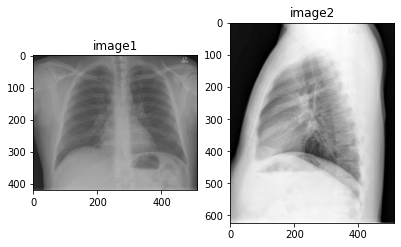

ACTUAL REPORT:  <sos> focal consolidation. visualized pneumothorax. pleural effusions. heart size normal. the cardiomediastinal silhouette unremarkable.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6137941510701352
time taken for evaluation is  2.159524440765381
****************************************************************************************************


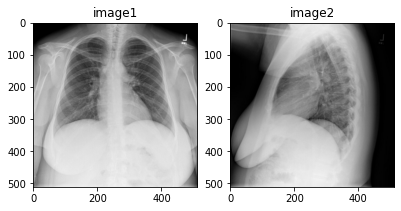

ACTUAL REPORT:  <sos> the heart pulmonary and mediastinum are within normal limits. there pleural effusion pneumothorax. there focal air space opacity suggest pneumonia. there are minimal degenerative changes the spine.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
time taken for evaluation is  2.3411669731140137
****************************************************************************************************


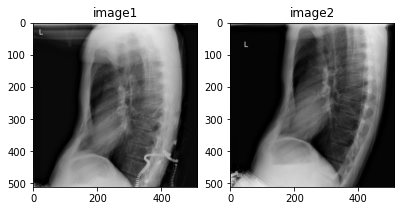

ACTUAL REPORT:  <sos> hyperinflated lungs with flattened diaphragm and increased retrosternal airspace. alveolar consolidation findings pleural effusion pulmonary edema. heart size within normal limits. right hilar calcification suggests previous granulomatous process.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
time taken for evaluation is  2.6336824893951416
****************************************************************************************************


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  start=time.time()
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

 

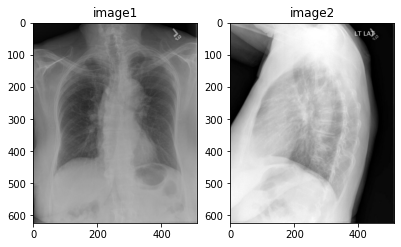

ACTUAL REPORT:  <sos> the heart normal size. the mediastinum stable with tortuous aorta. there are chronic changes particularly noted the lung apices. the are mildly prominent but stable. acute infiltrate seen. there pleural effusion.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
time taken for evaluation is  2.0893971920013428
****************************************************************************************************


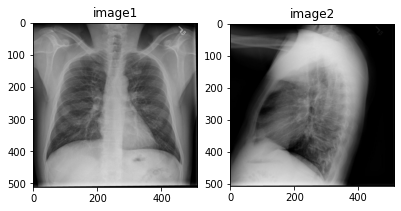

ACTUAL REPORT:  <sos> the heart and mediastinum are unremarkable. the lungs are clear without infiltrate. there effusion pneumothorax. there old healed fracture through the right rib.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
time taken for evaluation is  1.9166162014007568
****************************************************************************************************


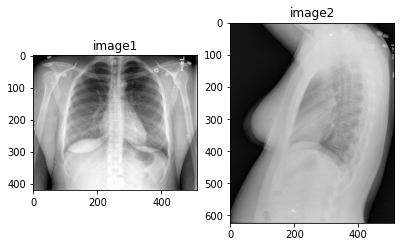

ACTUAL REPORT:  <sos> heart size normal. lungs are clear. are normal. pneumonia effusions edema pneumothorax adenopathy nodules masses.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
time taken for evaluation is  2.112553834915161
****************************************************************************************************


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  start=time.time()
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

 

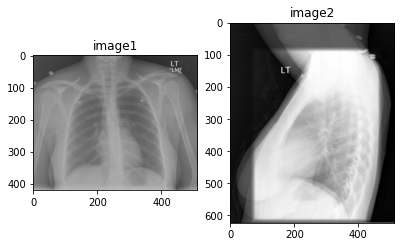

ACTUAL REPORT:  <sos> the lungs are clear without evidence focal airspace disease. there evidence pneumothorax large pleural effusion. the cardiac and mediastinal contours are within normal limits. the are unremarkable.  <eos>
GENERATED REPORT:  the cardiomediastinal silhouette within normal limits for size and contour. the lungs are normally inflated without evidence focal airspace disease pleural effusion pneumothorax. osseous structures are within normal limits for patient age.. <eos> 
BLEU SCORE IS:  0.5583140693907674
****************************************************************************************************


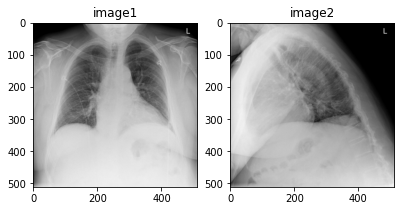

ACTUAL REPORT:  <sos> heart size and mediastinal contour are normal. pulmonary vascularity normal. lungs are clear. pleural effusions pneumothoraces. degenerative changes the thoracic spine.  <eos>
GENERATED REPORT:  the heart size and pulmonary vascularity appear within normal limits. the lungs are free focal airspace disease. pleural effusion pneumothorax seen. <eos> 
BLEU SCORE IS:  0.6272921978395489
****************************************************************************************************


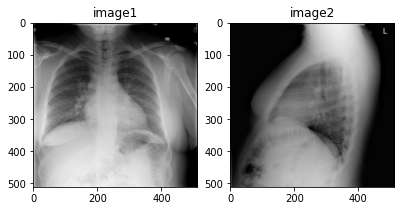

ACTUAL REPORT:  <sos> stable heart size mediastinal silhouette. overt edema. focal consolidation pleural effusion pneumothorax.  <eos>
GENERATED REPORT:  the heart size and pulmonary vascularity appear within normal limits. the lungs are free focal airspace disease. pleural effusion pneumothorax seen. <eos> 
BLEU SCORE IS:  0.6206532508321124
****************************************************************************************************


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)

 

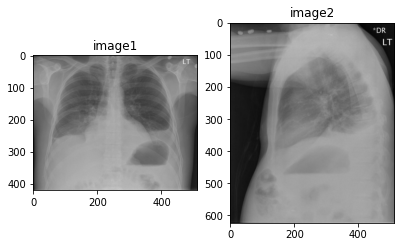

ACTUAL REPORT:  <sos> there bilateral lower lung airspace disease. there are small moderate sized bilateral pleural effusions left greater than right. there pneumothorax. mediastinal silhouette normal. calcified left hilar lymph .  <eos>
GENERATED REPORT:  the heart normal size. the mediastinum unremarkable. there pleural effusion pneumothorax focal airspace disease. chronic degenerative changes are present within the spine. <eos> 
BLEU SCORE IS:  0.6121812186746101
****************************************************************************************************


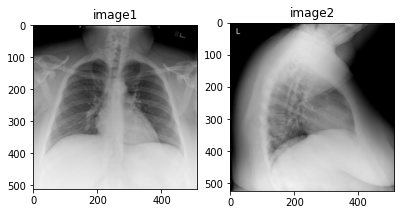

ACTUAL REPORT:  <sos> cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact.  <eos>
GENERATED REPORT:  the heart normal size. the mediastinum unremarkable. the lungs are clear. <eos> 
BLEU SCORE IS:  0.7071067811865476
****************************************************************************************************


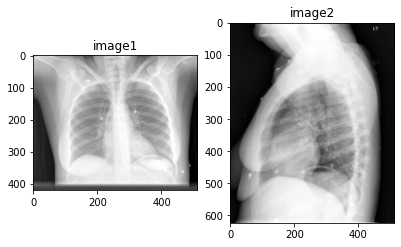

ACTUAL REPORT:  <sos> lungs are clear bilaterally. cardiac and mediastinal silhouettes are normal. pulmonary vasculature normal. pneumothorax pleural effusion. acute bony abnormality.  <eos>
GENERATED REPORT:  the heart size and pulmonary vascularity appear within normal limits. the lungs are free focal airspace disease. pleural effusion pneumothorax seen. <eos> 
BLEU SCORE IS:  0.6272921978395489
****************************************************************************************************


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)

 

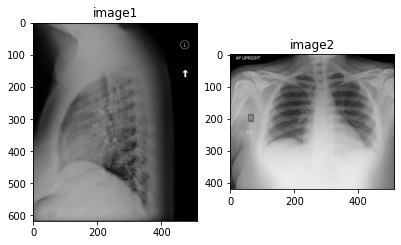

ACTUAL REPORT:  <sos> there are low lung volumes. the lungs are otherwise clear. focal airspace consolidation pleural effusion. calcific density the right lung apex compatible with calcified granuloma.  <eos>
GENERATED REPORT:  the heart size and mediastinal silhouette are within normal limits for contour. the lungs are clear. pneumothorax pleural effusions. the are intact. <eos> 
BLEU SCORE IS:  0.6206532508321124
****************************************************************************************************


In [ ]:
import random 
index=[100]

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)

 

In [ ]:
index=range(0,test.shape[0])
bl=0
start1=time.time()
for i in (index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result=evaluate(img1,img2) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)
end1=time.time() 
print("average bleu score on the test data is ",bl/test.shape[0])


average bleu score on the test data is  0.6190013006986763


In [ ]:
print('the average time taken for the evaluation is ',(end1-start1)/test.shape[0])

the average time taken for the evaluation is  1.009555993903994


**OBSERVATION:** We can see that the generated report is not exactly same as the actual report in all cases. For reports of shorter length(in the second example) the generated and actual reports are almost matching. The blues score is also good. But for longer reports(as seen in example 1 and 3), the sentences are different. The generated report is not able to show all the actual findings. Some important information are missing. Also, the bleu score for these cases are low

**CONCLUSION:** We need to build a better model, that can capture more information from the images